# <비율컬럼 추가>

In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [210]:
df = pd.read_csv('train.csv')

In [211]:
print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 85)

pandas version:  1.2.5


In [212]:
df.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수']

# 1. 데이터 오류 처리

In [213]:
error_list=['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988', 'C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C2675'] 
len(error_list)

15

In [214]:
df.단지코드.nunique()

423

In [215]:
code_list = [i for i in df.단지코드.unique() if i not in error_list]
len(code_list)

411

In [216]:
df_r = pd.DataFrame()

for i in code_list:
    temp = df[df.단지코드 == i]
    df_r = pd.concat([df_r, temp])

In [217]:
df_r.to_csv('data/train_0_semi.csv')

In [218]:
df = df_r.copy()

# 2.결측치 처리

In [219]:
df['임대료'] = df.임대료.replace('-', np.nan)
df['임대보증금'] = df.임대보증금.replace('-', np.nan)

In [220]:
df['임대료'] = df['임대료'].fillna(0)
df['임대보증금'] = df['임대보증금'].fillna(0)

### 지하철역수
- 대전은 1, 충청남도는 0

In [221]:
np.mean(df[df['지역'] == '대전광역시']['지하철역'])

0.7225433526011561

In [222]:
np.mean(df[df['지역'] == '충청남도']['지하철역'])

0.0

In [223]:
df['지하철역'] = np.where((df.지역 =='대전광역시') & (df['지하철역'].isnull()), 1, df['지하철역'])
df['지하철역'] = np.where((df.지역 =='충청남도') & (df['지하철역'].isnull()), 0, df['지하철역'])

# 3.이상치 처리

In [224]:
df.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수'],
      dtype='object')

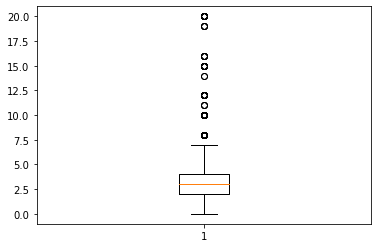

In [225]:
plt.boxplot(df['버스정류장'])
plt.show()

In [226]:
q25 = np.percentile(df['버스정류장'], 25)
q75 = np.percentile(df['버스정류장'], 75)
IQR = q75 - q25
df['버스정류장'] = np.where(df['버스정류장'] > 7, 7, df['버스정류장'])

In [227]:
np.mean(df['버스정류장']) 

3.409898919484141

(array([  2., 270., 774.,   0., 716., 485.,   0., 162., 153., 307.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

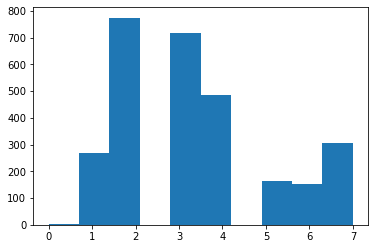

In [228]:
plt.hist(df['버스정류장'])

In [229]:
df.to_csv('data/train_1_semi.csv', index=False)

In [230]:
#전처리 완료
df = pd.read_csv('data/train_1_semi.csv')

# 4.그룹

### 공급유형 그룹

In [231]:
df['period'] = np.where((df.공급유형=='영구임대')|(df.공급유형=='공공임대(50년)')|(df.공급유형=='공공분양'), 'exL',
        np.where((df.공급유형=='국민임대')|(df.공급유형 =='장기전세'), 'L', 'S'))

In [232]:
# from collections import Counter

(array([1730.,    0.,    0.,    0.,    0.,  190.,    0.,    0.,    0.,
         949.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

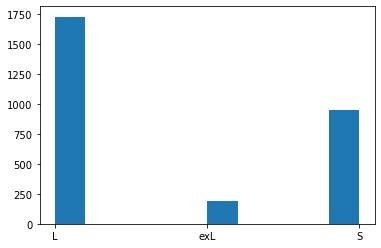

In [233]:
plt.hist(df.period)

### 자격유형 그룹

In [234]:
ls=[]
for i in df.공급유형.unique():
    temp = df[df.공급유형 == i]
    cert = temp.자격유형.unique()
    ls.append([i, cert])

- A : 공공임대(50년), 공공임대(10년), 공공임대(분납), 장기전세, 공공임대(5년) - 
- D : 임대상가, 공공분양 - 
- A, C, E, F, I : 영구임대
- J, K, L, M, N, O : 행복주택
- A, B, E, G, H : 국민임대

In [235]:
df['자격유형_cat'] = np.where(df.공급유형 =='행복주택', 'JKLMNO',
        np.where(df.공급유형 == '국민임대', 'ABEGH',
                np.where(df.공급유형 =='영구임대', 'ACEFI',
                        np.where((df.공급유형 =='임대상가') | (df.공급유형 =='공공분양'), 'D', 'A'))))

In [236]:
df['자격유형_cat'].unique()

array(['ABEGH', 'A', 'ACEFI', 'D', 'JKLMNO'], dtype=object)

(array([1727.,    0.,  219.,    0.,    0.,  152.,    0.,  569.,    0.,
         202.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

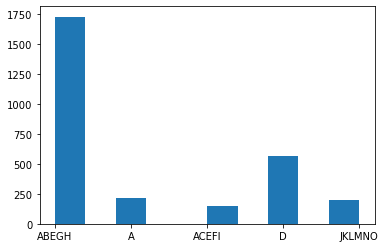

In [237]:
plt.hist(df['자격유형_cat'])

### 전용면적 그룹
- 상한선 100, 하한선 15

In [238]:
df.전용면적.describe()

count    2869.000000
mean       44.421394
std        32.072217
min        12.620000
25%        32.100000
50%        39.840000
75%        51.050000
max       583.400000
Name: 전용면적, dtype: float64

In [239]:
df['전용면적'] = df.전용면적//5 *5

In [240]:
df.전용면적 = np.where(df.전용면적 > 80, 80,
        np.where(df.전용면적 < 15, 15, df.전용면적))
df.전용면적 = df.전용면적.astype('int64')

In [241]:
df.전용면적.describe()

count    2869.000000
mean       39.855350
std        13.474432
min        15.000000
25%        30.000000
50%        35.000000
75%        50.000000
max        80.000000
Name: 전용면적, dtype: float64

(array([231., 322., 261., 697., 631., 376., 203.,   8.,  44.,  96.]),
 array([15. , 21.5, 28. , 34.5, 41. , 47.5, 54. , 60.5, 67. , 73.5, 80. ]),
 <BarContainer object of 10 artists>)

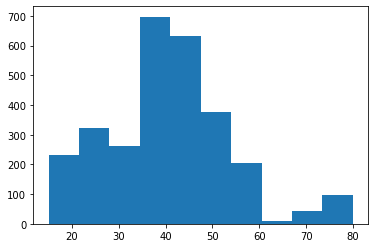

In [242]:
plt.hist(df.전용면적)

In [243]:
df

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수,period,자격유형_cat
0,C2515,545,아파트,경상남도,국민임대,30,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0,L,ABEGH
1,C2515,545,아파트,경상남도,국민임대,35,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0,L,ABEGH
2,C2515,545,아파트,경상남도,국민임대,35,20,17.0,A,12672000,107130,0.0,3.0,624.0,205.0,L,ABEGH
3,C2515,545,아파트,경상남도,국민임대,45,38,17.0,A,18433000,149760,0.0,3.0,624.0,205.0,L,ABEGH
4,C2515,545,아파트,경상남도,국민임대,45,19,17.0,A,18433000,149760,0.0,3.0,624.0,205.0,L,ABEGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,C2532,239,아파트,강원도,국민임대,45,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0,L,ABEGH
2865,C2532,239,아파트,강원도,국민임대,50,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0,L,ABEGH
2866,C2532,239,아파트,강원도,국민임대,50,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0,L,ABEGH
2867,C2532,239,아파트,강원도,국민임대,50,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0,L,ABEGH


# 5. 데이터프레임 만들기 시작

In [244]:
df1 = pd.DataFrame(df.groupby('단지코드').sum().reset_index()['단지코드'], columns=['단지코드']) #단지코드 데이터프레임

## 1) 임대건물구분

### 아파트/상가 세대수

In [245]:
df1 = pd.DataFrame(df.groupby('단지코드').sum()['전용면적별세대수'].reset_index()['단지코드'], columns = ['단지코드'])
temp = df.groupby(['단지코드', '임대건물구분']).sum()['전용면적별세대수'].reset_index()

df1 = df1.merge(temp.loc[temp['임대건물구분'] == '아파트'].reset_index(drop=True)[['단지코드','전용면적별세대수']], on = '단지코드', how = 'left')

df1.columns = ['단지코드','아파트세대수']

df1 = df1.merge(temp.loc[temp['임대건물구분'] == '상가'].reset_index(drop=True)[['단지코드','전용면적별세대수']], on = '단지코드', how = 'left' )

df1.columns = ['단지코드','아파트세대수', '상가세대수']

df1 = df1.fillna(0)

### 총세대수 & 아파트/상가 비율

In [246]:
# temp = df[['단지코드', '총세대수']].drop_duplicates() #총세대수
# df1 = df1.merge(temp, on='단지코드', how='left')

In [247]:
df1['총세대수'] = df1['아파트세대수'] + df1['상가세대수']

In [248]:
df1['아파트비율'] = df1['아파트세대수']/df1['총세대수']
df1['상가비율'] = df1['상가세대수']/df1['총세대수']

In [249]:
df1 = df1.drop(['아파트세대수', '상가세대수'], axis=1)

## 2) 기본정보 ★

In [250]:
#제외 : 총세대수, 임대건물구분(df1), 전용면적별세대수, 전용면적, 공급유형, 자격유형
#포함 : 단지코드, 지역, 공가수, 도보 10분거리 내 지하철역 수(환승노선 수 반영),  도보 10분거리 내 버스정류장 수, 단지내주차면수, 등록차량수

In [251]:
temp = df[['단지코드', '지역', '공가수', '지하철역',
                     '버스정류장', '단지내주차면수', '등록차량수']].drop_duplicates()
df1=df1.merge(temp, on='단지코드', how='left')

In [252]:
#비율만
df1.columns = ['단지코드', '총세대수', '아파트비율', '상가비율', '지역', '공가수',
       '지하철역', '버스정류장', '단지내주차면수',
       '등록차량수']

## 3) 전용면적

In [253]:
for i in df.sort_values('전용면적').전용면적.unique():
    temp = df[df.전용면적 ==i].groupby('단지코드').sum().reset_index()[['단지코드', '전용면적별세대수']]
    temp.columns = ['단지코드', '전용면적_{}_세대수'.format(i)]
    df1 = df1.merge(temp,on='단지코드', how='left')
    
df1 = df1.fillna(0)

## 4) 공급유형

### 공급유형 cat 비율

In [254]:
df2 = pd.DataFrame(df.groupby('단지코드').sum().reset_index()['단지코드'], columns=['단지코드']) #단지코드 데이터프레임

temp = df.groupby(['단지코드', 'period']).sum().reset_index()

temp1 = temp.loc[temp['period'] == 'exL'][['단지코드', '전용면적별세대수']]
temp1.columns = ['단지코드', '초장기세대수']
df2 = df2.merge(temp1, on = '단지코드', how = 'left')

temp2 = temp.loc[temp['period'] == 'L'][['단지코드', '전용면적별세대수']]
temp2.columns = ['단지코드', '장기세대수']
df2 = df2.merge(temp2, on = '단지코드', how = 'left')

temp3 = temp.loc[temp['period'] == 'S'][['단지코드', '전용면적별세대수']]
temp3.columns = ['단지코드', '단기세대수']
df2 = df2.merge(temp3, on = '단지코드', how = 'left')

df2 = df2.fillna(0)

In [255]:
df2['총세대수'] = df2['초장기세대수'] + df2['장기세대수'] + df2['단기세대수']
df2['초장기비율'] = df2['초장기세대수'] / df2['총세대수']
df2['장기비율'] = df2['장기세대수'] / df2['총세대수']
df2['단기비율'] = df2['단기세대수'] / df2['총세대수']
df2 = df2.drop(['초장기세대수', '장기세대수', '단기세대수', '총세대수'], axis=1)
df1 = df1.merge(df2, on='단지코드', how='left')

## 5) 자격유형

### 자격유형cat 비율

In [256]:
df['자격유형_cat'].unique()

array(['ABEGH', 'A', 'ACEFI', 'D', 'JKLMNO'], dtype=object)

In [257]:
df2 = pd.DataFrame(df.groupby('단지코드').sum().reset_index()['단지코드'], columns=['단지코드']) #단지코드 데이터프레임

temp = df.groupby(['단지코드', '자격유형_cat']).sum().reset_index()

temp1 = temp.loc[temp['자격유형_cat'] == 'ABEGH'][['단지코드', '전용면적별세대수']]
temp1.columns = ['단지코드', 'ABEGH세대수']
df2 = df2.merge(temp1, on = '단지코드', how = 'left')

temp2 = temp.loc[temp['자격유형_cat'] == 'A'][['단지코드', '전용면적별세대수']]
temp2.columns = ['단지코드', 'A세대수']
df2 = df2.merge(temp2, on = '단지코드', how = 'left')

temp3 = temp.loc[temp['자격유형_cat'] == 'ACEFI'][['단지코드', '전용면적별세대수']]
temp3.columns = ['단지코드', 'ACEFI세대수']
df2 = df2.merge(temp3, on = '단지코드', how = 'left')

temp4 = temp.loc[temp['자격유형_cat'] == 'D'][['단지코드', '전용면적별세대수']]
temp4.columns = ['단지코드', 'D세대수']
df2 = df2.merge(temp4, on = '단지코드', how = 'left')

temp5 = temp.loc[temp['자격유형_cat'] == 'JKLMNO'][['단지코드', '전용면적별세대수']]
temp5.columns = ['단지코드', 'JKLMNO세대수']
df2 = df2.merge(temp5, on = '단지코드', how = 'left')

df2 = df2.fillna(0)

df2['총세대수'] = df2.iloc[:, 1] + df2.iloc[:, 2] + df2.iloc[:, 3] + df2.iloc[:, 4] + df2.iloc[:, 5]
df2['ABEGH비율'] = df2['ABEGH세대수'] / df2['총세대수']
df2['A비율'] = df2['A세대수'] / df2['총세대수']
df2['ACEFI비율'] = df2['ACEFI세대수'] / df2['총세대수']
df2['D비율'] = df2['D세대수'] / df2['총세대수']
df2['JKLMNO비율'] = df2['JKLMNO세대수'] / df2['총세대수']

In [258]:
df2 = df2.drop(['ABEGH세대수', 'A세대수', 'ACEFI세대수', 'D세대수', 'JKLMNO세대수', '총세대수'], axis=1)

In [259]:
df1 = df1.merge(df2, on='단지코드', how='left')

## 6) 나이/성별 인구수
- 나이대별로 합치는건 결과에 그다지 영향 안 미침. 그대로 붙여도 무관

In [260]:
ageinfo = pd.read_csv('data/age_gender_info.csv')
df1 = df1.merge(ageinfo, on = '지역', how = 'left')

In [261]:
# age = pd.DataFrame()
# for i in range(11):
#     age['지역'] = ageinfo['지역']
#     age['{}0대'.format(i)] = ageinfo.iloc[:, (2*i)+1] + ageinfo.iloc[:, 2*i+2]

## 7) 1인당 자동차등록수

In [262]:
car_2019 = pd.read_csv('data/1인당자동차_2019.csv', encoding='euc-kr', header=1)

In [263]:
car_2019.columns = ['지역', '1인당_자동차등록대수', '자동차등록대수', '주민등록인구']
car_2019['1인당자동차'] = car_2019.자동차등록대수 / car_2019.주민등록인구
car_2019 = car_2019[['지역', '1인당자동차']]
df1 = df1.merge(car_2019, on='지역', how='left')

## 8) 주택연면적

In [264]:
size = pd.read_csv('data/주택연면적_2019.csv', encoding='euc-kr', header=1)

In [265]:
size = size[['행정구역별(시군구)', '2019년']].iloc[4:, :].reset_index(drop=True)
size.columns = ['지역', '연면적']

In [266]:
df1 = df1.merge(size, on='지역', how='left')

## 9) 평당가격

In [267]:
price = pd.read_csv('data/평균분양가격_2019.csv', encoding='euc-kr', header=1)
price = price[['지역별(2)', '전체.11']]
price = price.iloc[2:, :]
idx = price.index.difference([5]).difference([12]).difference([3])
price = price.loc[idx, :].reset_index(drop=True)
price.columns = ['지역', '평균분양가격']

In [268]:
price['지역'] = df.sort_values('지역').지역.unique()

In [269]:
df1 = df1.merge(price, on='지역', how='left')

### 자전거도로현황

In [270]:
bicycle = pd.read_csv('data/자전거도로_2019.csv', encoding='euc-kr', header=1)
bicycle = bicycle.iloc[:, :2]
bicycle.columns = ['지역', '자전거도로']

In [271]:
df1 = df1.merge(bicycle, on='지역', how='left')

## 10) 총면적구하기 ★

In [272]:
size_ls = df.sort_values('전용면적')['전용면적'].unique()

In [273]:
len(size_ls)

14

비율만

In [274]:
all_size=0
for i in range(14):
    all_size += df1.iloc[:,i+10] * size_ls[i]

In [275]:
df1['총면적'] = all_size

## 11) 규모별 가격

In [276]:
df1['규모별가격'] = df1['총면적'] * df1['평균분양가격']

In [277]:
df1.shape

(411, 60)

In [279]:
df1

,단지코드,총세대수,아파트비율,상가비율,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,전용면적_15_세대수,전용면적_20_세대수,전용면적_25_세대수,전용면적_30_세대수,전용면적_35_세대수,전용면적_40_세대수,전용면적_45_세대수,전용면적_50_세대수,전용면적_55_세대수,전용면적_60_세대수,전용면적_65_세대수,전용면적_70_세대수,전용면적_75_세대수,전용면적_80_세대수,초장기비율,장기비율,단기비율,ABEGH비율,A비율,ACEFI비율,D비율,JKLMNO비율,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),1인당자동차,연면적,평균분양가격,자전거도로,총면적,규모별가격
0,C1000,566.0,1.00000,0.00000,충청북도,10.0,0.0,1.0,438.0,481.0,0.0,0.0,0.0,0.0,419.0,0.0,72.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.034678,0.035339,0.059808,0.061570,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037,0.523499,11343,3882,1252.56,21655.0,84064710.0
1,C1004,521.0,0.96737,0.03263,충청남도,3.0,0.0,2.0,153.0,93.0,3.0,7.0,1.0,2.0,506.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.96737,0.0,0.03263,0.0,0.0,0.96737,0.03263,0.0,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123,0.526493,7879,3063,1286.98,18110.0,55470930.0
2,C1005,1144.0,1.00000,0.00000,충청남도,16.0,0.0,7.0,950.0,376.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,904.0,240.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123,0.526493,7879,3063,1286.98,58400.0,178879200.0
3,C1013,1308.0,1.00000,0.00000,광주광역시,16.0,0.0,6.0,1119.0,1665.0,0.0,0.0,0.0,0.0,291.0,0.0,757.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,0.079183,0.079902,0.067443,0.075930,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013,0.464329,13393,3834,661.39,57250.0,219496500.0
4,C1014,996.0,1.00000,0.00000,전라북도,5.0,0.0,2.0,823.0,708.0,0.0,0.0,0.0,516.0,0.0,0.0,280.0,116.0,84.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013,0.510777,10146,2452,1415.90,38500.0,94402000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,C2663,772.0,1.00000,0.00000,경기도,14.0,0.0,3.0,700.0,652.0,0.0,0.0,112.0,0.0,220.0,0.0,320.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067,0.435486,126879,4493,5637.69,30900.0,138833700.0
407,C2666,1084.0,1.00000,0.00000,부산광역시,23.0,0.0,1.0,837.0,701.0,0.0,0.0,0.0,0.0,458.0,0.0,626.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028,0.408684,22752,3458,461.20,44200.0,152843600.0
408,C2670,648.0,1.00000,0.00000,전라북도,9.0,0.0,2.0,600.0,435.0,0.0,0.0,0.0,192.0,312.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.0

In [282]:
df1.columns

Index(['단지코드', '총세대수', '아파트비율', '상가비율', '지역', '공가수', '지하철역', '버스정류장',
       '단지내주차면수', '등록차량수', '전용면적_15_세대수', '전용면적_20_세대수', '전용면적_25_세대수',
       '전용면적_30_세대수', '전용면적_35_세대수', '전용면적_40_세대수', '전용면적_45_세대수',
       '전용면적_50_세대수', '전용면적_55_세대수', '전용면적_60_세대수', '전용면적_65_세대수',
       '전용면적_70_세대수', '전용면적_75_세대수', '전용면적_80_세대수', '초장기비율', '장기비율', '단기비율',
       'ABEGH비율', 'A비율', 'ACEFI비율', 'D비율', 'JKLMNO비율', '10대미만(여자)',
       '10대미만(남자)', '10대(여자)', '10대(남자)', '20대(여자)', '20대(남자)', '30대(여자)',
       '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)', '60대(여자)',
       '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)', '90대(여자)',
       '90대(남자)', '100대(여자)', '100대(남자)', '1인당자동차', '연면적', '평균분양가격', '자전거도로',
       '총면적', '규모별가격'],
      dtype='object')

In [285]:
heatmap_data = df1[['총세대수', '아파트비율', '상가비율', '공가수', '지하철역', '버스정류장',
       '단지내주차면수', '등록차량수', '전용면적_15_세대수', '전용면적_20_세대수', '전용면적_25_세대수',
       '전용면적_30_세대수', '전용면적_35_세대수', '전용면적_40_세대수', '전용면적_45_세대수',
       '전용면적_50_세대수', '전용면적_55_세대수', '전용면적_60_세대수', '전용면적_65_세대수',
       '전용면적_70_세대수', '전용면적_75_세대수', '전용면적_80_세대수', '1인당자동차', '연면적', '평균분양가격', '자전거도로',
       '총면적', '규모별가격']]

<AxesSubplot:title={'center':'Person Correlation of Features'}>

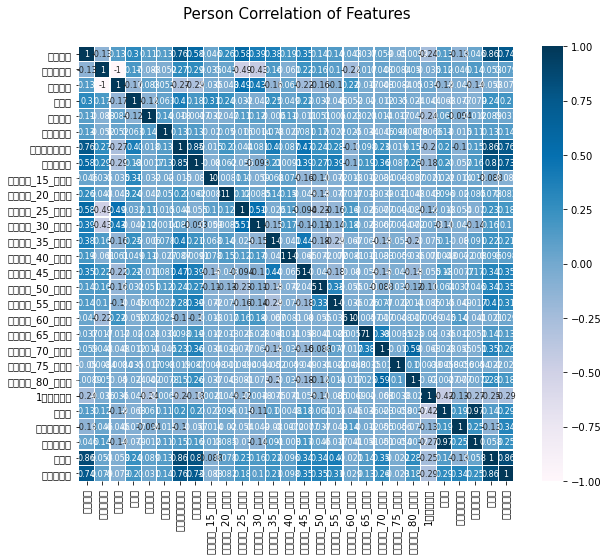

In [287]:
colormap = plt.cm.PuBu

plt.figure(figsize=(10, 8))
           
plt.title("Person Correlation of Features", y = 1.05, size = 15)

sns.heatmap(heatmap_data.astype(float).corr(), \
                        linewidths = 0.1, vmax = 1.0, square = True, \
                        cmap = colormap, linecolor = "white", \
                        annot = True, annot_kws = {"size" : 8})

In [288]:
corr_df = heatmap_data.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

,총세대수,아파트비율,상가비율,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,전용면적_15_세대수,전용면적_20_세대수,전용면적_25_세대수,전용면적_30_세대수,전용면적_35_세대수,전용면적_40_세대수,전용면적_45_세대수,전용면적_50_세대수,전용면적_55_세대수,전용면적_60_세대수,전용면적_65_세대수,전용면적_70_세대수,전용면적_75_세대수,전용면적_80_세대수,1인당자동차,연면적,평균분양가격,자전거도로,총면적,규모별가격
총세대수,1.00,-0.13,0.13,0.30,0.11,0.13,0.76,0.58,0.05,0.26,0.58,0.39,0.38,0.19,0.35,0.14,0.14,0.04,0.04,0.06,-0.05,-0.01,-0.24,0.13,-0.13,0.05,0.86,0.74
아파트비율,-0.13,1.00,-1.00,0.17,-0.08,-0.05,0.27,0.29,0.04,0.04,-0.49,-0.43,0.16,-0.06,0.22,0.16,0.10,-0.22,0.02,0.05,0.01,0.05,-0.04,0.12,0.05,0.14,0.05,0.08
상가비율,0.13,-1.00,1.00,-0.17,0.08,0.05,-0.27,-0.29,-0.04,-0.04,0.49,0.43,-0.16,0.06,-0.22,-0.16,-0.10,0.22,-0.02,-0.05,-0.01,-0.05,0.04,-0.12,-0.05,-0.14,-0.05,-0.08
공가수,0.30,0.17,-0.17,1.00,-0.12,0.06,0.40,0.18,0.31,0.24,0.03,-0.04,0.25,0.05,0.22,0.03,-0.04,-0.05,-0.02,-0.01,0.04,-0.02,-0.04,-0.06,-0.08,-0.08,0.24,0.20
지하철역,0.11,-0.08,0.08,-0.12,1.00,0.14,0.02,-0.00,-0.03,-0.05,0.11,0.12,-0.01,0.11,-0.01,0.05,0.01,0.02,0.02,0.01,-0.02,-0.04,-0.24,0.06,-0.09,-0.01,0.09,0.03
버스정류장,0.13,-0.05,0.05,0.06,0.14,1.00,0.13,0.13,-0.02,0.05,0.02,0.00,0.08,-0.03,0.08,0.12,0.02,0.02,-0.03,-0.05,0.10,-0.01,-0.01,0.11,-0.02,0.11,0.13,0.14
단지내주차면수,0.76,0.27,-0.27,0.40,0.02,0.13,1.00,0.85,-0.01,0.20,0.04,0.08,0.40,0.09,0.47,0.24,0.28,-0.10,0.10,0.23,0.02,0.15,-0.20,0.20,-0.10,0.15,0.86,0.76
등록차량수,0.58,0.29,-0.29,0.18,-0.00,0.13,0.85,1.00,-0.08,0.06,-0.06,-0.09,0.21,0.01,0.39,0.27,0.39,-0.10,0.19,0.36,0.09,0.26,-0.18,0.20,-0.06,0.16,0.80,0.73
전용면적_15_세대수,0.05,0.04,-0.04,0.31,-0.03,-0.02,-0.01,-0.08,1.00,-0.01,0.10,-0.06,0.07,0.08,-0.16,-0.11,-0.07,-0.01,-0.01,-0.03,-0.01,-0.04,0.00,0.02,-0.01,0.02,-0.09,-0.08
전용면적_20_세대수,0.26,0.04,-0.04,0.24,-0.05,0.05,0.20,0.06,-0.01,1.00,0.12,0.01,0.14,0.15,-0.05,-0.13,-0.08,-0.02,-0.01,-0.04,-0.01,-0.04,-0.05,0.10,-0.02,0.09,0.08,0.08


In [289]:
s = corr_df.unstack()
s

총세대수   총세대수      1.00
       아파트비율    -0.13
       상가비율      0.13
       공가수       0.30
       지하철역      0.11
                 ... 
규모별가격  연면적       0.29
       평균분양가격    0.34
       자전거도로     0.25
       총면적       0.86
       규모별가격     1.00
Length: 784, dtype: float64

In [290]:
df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

## 12) 지역인코딩

In [205]:
df1 = pd.concat([df1.drop('지역', axis = 1),pd.get_dummies(df1.지역)], axis = 1)

In [206]:
# df1.to_csv('data/train_2_semi.csv', index=False) #비율만

In [207]:
# df1.to_csv('data/train_3_semi.csv', index=False) #비율 + 여부

### 비율만 넣은 것

In [132]:
#df1 = pd.read_csv('train_ratio.csv') #비율만 넣은 것

In [208]:
df1

,단지코드,총세대수,아파트비율,상가비율,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,전용면적_15_세대수,전용면적_20_세대수,전용면적_25_세대수,전용면적_30_세대수,전용면적_35_세대수,전용면적_40_세대수,전용면적_45_세대수,전용면적_50_세대수,전용면적_55_세대수,전용면적_60_세대수,전용면적_65_세대수,전용면적_70_세대수,전용면적_75_세대수,전용면적_80_세대수,초장기비율,장기비율,단기비율,ABEGH비율,A비율,ACEFI비율,D비율,JKLMNO비율,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),1인당자동차,연면적,평균분양가격,자전거도로,총면적,규모별가격,강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,서울특별시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
0,C1000,566.0,1.00000,0.00000,10.0,0.0,1.0,438.0,481.0,0.0,0.0,0.0,0.0,419.0,0.0,72.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.034678,0.035339,0.059808,0.061570,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037,0.523499,11343,3882,1252.56,21655.0,84064710.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,C1004,521.0,0.96737,0.03263,3.0,0.0,2.0,153.0,93.0,3.0,7.0,1.0,2.0,506.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.96737,0.0,0.03263,0.0,0.0,0.96737,0.03263,0.0,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123,0.526493,7879,3063,1286.98,18110.0,55470930.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,C1005,1144.0,1.00000,0.00000,16.0,0.0,7.0,950.0,376.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,904.0,240.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123,0.526493,7879,3063,1286.98,58400.0,178879200.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,C1013,1308.0,1.00000,0.00000,16.0,0.0,6.0,1119.0,1665.0,0.0,0.0,0.0,0.0,291.0,0.0,757.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,0.079183,0.079902,0.067443,0.075930,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013,0.464329,13393,3834,661.39,57250.0,219496500.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,C1014,996.0,1.00000,0.00000,5.0,0.0,2.0,823.0,708.0,0.0,0.0,0.0,516.0,0.0,0.0,280.0,116.0,84.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013,0.510777,10146,2452,1415.90,38500.0,94402000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,C2663,772.0,1.00000,0.00000,14.0,0.0,3.0,700.0,652.0,0.0,0.0,112.0,0.0,220.0,0.0,320.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067,0.435486,126879,4493,5637.69,30900.0,138833700.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
407,C2666,1084.0,1.00000,0.00000,23.0,0.0,1.0,837.0,701.0,0.0,0.0,0.0,0.0,458.0,0.0,626.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.00000,1.0,0.0,0.00000,0.00000,0.0,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028,0.408684,22752,3458,461.20,44200.0,152843600.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
408,C2670,648.0,1.00000,0.00

# 모델링

In [133]:
print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 85)

pandas version:  1.2.5


In [134]:
from sklearn.linear_model import LinearRegression   ## 회귀 분석
from sklearn.svm import SVC                         ## svm 분류모델
from sklearn.tree import DecisionTreeClassifier     ## Tree 분류모델
from sklearn.ensemble import RandomForestClassifier ## RandomForet
from sklearn.linear_model import LogisticRegression ## Logistic Regression
from sklearn.ensemble import RandomForestRegressor  ## RandomForet 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
import pickle

### X,y

In [135]:
df1 = df1.drop('전용면적_65_세대수', axis=1)
df1 = df1.drop('서울특별시', axis=1)

In [918]:
x = df1.columns.difference(['등록차량수'], sort=False).difference(['단지코드'], sort=False)
# x = ['임대건물구분_아파트', '임대건물구분_상가', '공가수', '지하철역 수', '버스정류장 수', '단지내주차면수']
X= df1[x]
y = pd.DataFrame(df1['등록차량수'])

In [919]:
X.shape

(411, 80)

In [891]:
model = sm.OLS(y, X)
result = model.fit()

In [892]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  등록차량수   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     57.23
Date:                Tue, 27 Jul 2021   Prob (F-statistic):          5.71e-135
Time:                        23:59:41   Log-Likelihood:                -2621.3
No. Observations:                 411   AIC:                             5327.
Df Residuals:                     369   BIC:                             5495.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
총세대수           -0.7561      0.828     -0.913      

## Modeling

In [948]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [949]:
from sklearn.linear_model import LinearRegression   ## 회귀 분석
from sklearn.svm import SVC                         ## svm 분류모델
from sklearn.tree import DecisionTreeClassifier     ## Tree 분류모델
from sklearn.ensemble import RandomForestClassifier ## RandomForet
from sklearn.linear_model import LogisticRegression ## Logistic Regression
from sklearn.ensemble import RandomForestRegressor  ## RandomForet 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor

In [950]:
cols1 = ['Linear', 'ExtraTrees', 'Gradient', 'RandomForest', 'ElasticNet', 'Ridge', 'Lasso', 'XGB', 'Catboost', 'Voting1', 'Voting2', 'Voting3']

In [951]:
ls1=[]
ls2=[]
lr=LinearRegression()
dt = ExtraTreesRegressor(random_state=1)
gbr = GradientBoostingRegressor(random_state=1)
rfr = RandomForestRegressor(random_state=1)
ela = ElasticNet(random_state=1)
rg = Ridge(random_state=1)
las = Lasso(random_state=1)
xg = XGBRegressor(random_state=1)
cb = CatBoostRegressor(depth = 6, iterations=100, learning_rate=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
gbr.fit(X_train, y_train)
rfr.fit(X_train,y_train)
ela.fit(X_train, y_train)
rg.fit(X_train,y_train)
las.fit(X_train,y_train)
xg.fit(X_train,y_train)
cb.fit(X_train, y_train)
ereg1 = VotingRegressor([('xg', xg), ('ela', ela), ('las', las)])
ereg1.fit(X_train, y_train)
ereg2 = VotingRegressor([('rfr', rfr), ('ela', ela), ('las', las)])
ereg2.fit(X_train, y_train)
ereg3 = VotingRegressor([('cb', cb), ('ela', ela), ('las', las)])
ereg3.fit(X_train, y_train)
    
ls1.append(round(mean_absolute_error(y_test, lr.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, dt.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, gbr.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, rfr.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, ela.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, rg.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, las.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, xg.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, cb.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, ereg1.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, ereg2.predict(X_test)),3))
ls1.append(round(mean_absolute_error(y_test, ereg3.predict(X_test)),3))

ls2.append(round(mean_absolute_error(y_train, lr.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, dt.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, gbr.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, rfr.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, ela.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, rg.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, las.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, xg.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, cb.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, ereg1.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, ereg2.predict(X_train)),3))
ls2.append(round(mean_absolute_error(y_train, ereg3.predict(X_train)),3))

ls1 = np.array(ls1)
ls1 = ls1.reshape(-1, 12)
result_test = pd.DataFrame(ls1, columns=cols1)

ls2 = np.array(ls2)
ls2 = ls2.reshape(-1, 12)
result_train = pd.DataFrame(ls2, columns=cols1)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0:	learn: 364.2606921	total: 2.14ms	remaining: 212ms
1:	learn: 345.2866364	total: 4.55ms	remaining: 223ms
2:	learn: 328.7366897	total: 6.76ms	remaining: 219ms
3:	learn: 315.8349789	total: 8.87ms	remaining: 213ms
4:	learn: 301.1659781	total: 10.9ms	remaining: 206ms
5:	learn: 288.7312018	total: 13.1ms	remaining: 205ms
6:	learn: 279.4926184	total: 15.2ms	remaining: 202ms
7:	learn: 270.6695218	total: 17.4ms	remaining: 200ms
8:	learn: 260.0342627	total: 19.5ms	remaining: 197ms
9:	learn: 250.7738131	total: 21.3ms	remaining: 192ms
10:	learn: 240.9953892	total: 23.3ms	remaining: 189ms
11:	learn: 232.9180745	total: 25.3ms	remaining: 186ms
12:	learn: 224.2485324	total: 27.2ms	remaining: 182ms
13:	learn: 217.7508162	total: 29.1ms	remaining: 179ms
14:	learn: 210.8305903	total: 31.1ms	remaining: 176ms
15:	learn: 205.1023779	total: 32.9ms	remaining: 173ms
16:	learn: 199.3467950	total: 34.7ms	remaining: 170ms
17:	learn: 194.8732256	total: 36.5ms	remaining: 166ms
18:	learn: 189.9492533	total: 38.5ms	r

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0:	learn: 364.2606921	total: 3.42ms	remaining: 339ms
1:	learn: 345.2866364	total: 6.04ms	remaining: 296ms
2:	learn: 328.7366897	total: 8.53ms	remaining: 276ms
3:	learn: 315.8349789	total: 10.6ms	remaining: 255ms
4:	learn: 301.1659781	total: 12.8ms	remaining: 244ms
5:	learn: 288.7312018	total: 14.6ms	remaining: 229ms
6:	learn: 279.4926184	total: 16.6ms	remaining: 220ms
7:	learn: 270.6695218	total: 18.6ms	remaining: 214ms
8:	learn: 260.0342627	total: 20.8ms	remaining: 210ms
9:	learn: 250.7738131	total: 22.8ms	remaining: 205ms
10:	learn: 240.9953892	total: 25ms	remaining: 202ms
11:	learn: 232.9180745	total: 27.2ms	remaining: 200ms
12:	learn: 224.2485324	total: 29.5ms	remaining: 197ms
13:	learn: 217.7508162	total: 31.7ms	remaining: 195ms
14:	learn: 210.8305903	total: 33.8ms	remaining: 192ms
15:	learn: 205.1023779	total: 35.9ms	remaining: 189ms
16:	learn: 199.3467950	total: 38.1ms	remaining: 186ms
17:	learn: 194.8732256	total: 40.1ms	remaining: 183ms
18:	learn: 189.9492533	total: 42.2ms	rem

In [952]:
result_test

,Linear,ExtraTrees,Gradient,RandomForest,ElasticNet,Ridge,Lasso,XGB,Catboost,Voting1,Voting2,Voting3
0,100.607,115.619,124.76,115.436,125.639,97.738,96.012,125.422,112.664,105.819,105.12,105.74


In [953]:
result_train

,Linear,ExtraTrees,Gradient,RandomForest,ElasticNet,Ridge,Lasso,XGB,Catboost,Voting1,Voting2,Voting3
0,101.468,0.0,51.618,44.778,126.447,101.251,102.781,0.414,70.31,72.933,85.862,93.787


In [910]:
feature_df = pd.DataFrame({'X' : X.columns, '변수중요도':xg.feature_importances_})
feature_df.sort_values('변수중요도', ascending=False)

,X,변수중요도
6,단지내주차면수,0.213751
27,JKLMNO비율,0.118544
53,총면적,0.112933
61,대전광역시,0.112622
43,70대(남자),0.094958
1,아파트비율,0.032990
28,10대미만(여자),0.028399
24,A비율,0.026527
31,10대(남자),0.025616
34,30대(여자),0.024195


In [954]:
with open('model_ereg1_ratio_scaled.pickle', 'wb') as fp:
    pickle.dump(ereg1, fp)
print('저장완료')

저장완료


In [926]:
with open('model_ereg1_ratio_count.pickle', 'wb') as fp:
    pickle.dump(ereg1, fp)
print('저장완료')

저장완료
